# Time Series Analysis: "The Final Project"

`End? No, the journey doesn't end here. Death is just another path. One that we all must take.
-J.R.R. Tolkien, The Return of the King`

---

## Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from pandas.plotting import register_matplotlib_converters
from IPython.display import display
from tsa_functions import *

register_matplotlib_converters()
sns.set_style('darkgrid')

np.set_printoptions(precision=4)
pd.set_option('precision', 4)

import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import warnings

warnings.filterwarnings('ignore')

def rmsse(y_true, y_pred, ts):
    score = np.sqrt(np.mean((y_true - y_pred)**2)/np.mean((ts[1:] - ts[:-1])**2))
    return score

---

## M5 Forecasting

For this "final project", we will be forecasting the <b><u>level 9</b></u> series (unit sales of all products, aggregated for each store and department).

Load `sales_train_evaluation.csv` and use observations from `d_1 to d_1913` for training and `d_1914 to d_1941` for testing.

---

## Part 5. King of the Hill (20 pts.)

Using whatever methods/models you desire, beat the best `WRMSSE` score in Q5.

<b><u>Do not tune your model using the test set!</b></u> If you do, you will not get points for this part.

### Q8. (10 pts.)

Describe your methodology here. 

Points will be awarded for <b>aesthetics</b> (ex. use of diagrams), <b>ease of reading</b>, <b>clarity</b>, and <b>brevity</b>.

Points will be deducted for <b>excessively long</b> walls of text and descriptions.

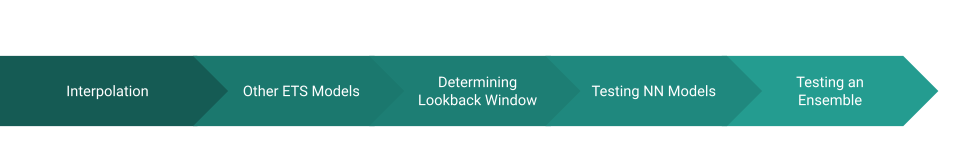

Our process of improving on the WRMSSE in part one explores three tracts—the first is simply other ETS configurations, the second is some simple RNNs and LSTMs, and finally an ensemble solution.  The stages in this process are as follows:<br>
1. As a sort of pre-work, the first step for this series of experiments is to make the interpolation process more sophisticated.  Whereas previously we simply used Pandas' time interpolation, for the experiments we interpolated the values using Light GBM.  For values not solved by the interpolation, we defaulted to backfilling NaN values, as before.<br><br>
2. For the simplest round of experiments, we started with going through the permutations of the ETS model configurations (different combinations of `add` or `mul` for error, trend, and season).  <b>In terms of simply getting a better WRMSSE, we have achieved it with the (M,M,M) ETS model.</b><br><br>
3. Before proceeding into the neural network modeling itself, we took the time to determine the optimum lookback window for our data. For this we again used Light GBM to test through five possible values in the range of one week to one month.  Also, rather than using a single lookback window for all, we used the hypertuned window for each index in our data.<br><br>
4. The next part had three different sections: the first to test different RNN architectures, the second to repeat the same for LSTM architectures, and finally to also experiment with a seq2seq model. Note that for all the neural network models, forecasts were made using a single-shot approach. <b>From the results of this stage, we also added the layer of decomposing each time-series into trend, 7-day seasonality, and residuals for our final phase.</b><br><br>
5. For the final experiment, we combined most of our better performing models as an ensemble forecaster, with inclusion based on the calculated (W)RMSSE.

### Q9. (10 pts.)

This part is for your actual code.

In [6]:
def xy(data, lb, h):
    x = []
    y = []
    
    for i in range(data.shape[0]):
        if i+lb+h > data.shape[0]:
            break
        x.append(data.iloc[i : i+lb].values)
        y.append(data.iloc[i+lb : i+lb+h].values)
    
    return np.asarray(x), np.asarray(y)

In [7]:
# Interpolation
def interpolate(data, key, lb, h):
    df_train = data.loc[key].astype(float)
    df_train = df_train.apply(lambda x: np.nan if x < 10 else x)
    na_loc = df_train[df_train.isna().ravel()].index.values
#     print(len(na_loc))
                
    train_x, train_y = xy(df_train, lb, h)
#     print(train_x[:3])
    
    test_loc = np.isnan(train_y.ravel()).ravel()
    train_loc = np.any(~np.isnan(train_x[~test_loc]), axis=1)
    
    if np.any(test_loc):
        test_x, test_y = train_x[test_loc], train_y[test_loc]
        train_x, train_y = train_x[~test_loc], train_y[~test_loc]
        train_x, train_y = train_x[train_loc], train_y[train_loc]
#         print(len(test_y))

        model = lgb.LGBMRegressor(random_state=1)
        model.fit(train_x, train_y)

        y_pred = model.predict(test_x).ravel()
        if len(na_loc)!=len(test_y):
            pad_x = len(na_loc) - len(test_y)
            y_pred = np.pad(y_pred, ((pad_x, 0),), constant_values=np.nan)
#             print(y_pred)
            
        df_train.loc[na_loc] = y_pred
    return df_train.ravel()

In [8]:
# folder = 'm5 class exercise/'
# calendar = pd.read_csv(f'{folder}calendar.csv')
# train_val = pd.read_csv(f'{folder}sales_train_validation.csv')
# train_eval = pd.read_csv(f'{folder}sales_train_evaluation.csv')

calendar = pd.read_csv(f'calendar.csv')
train_val = pd.read_csv(f'sales_train_validation.csv')
train_eval = pd.read_csv(f'sales_train_evaluation.csv')

train_eval_l9 = train_eval.groupby(['store_id', 'dept_id']).sum()
# train_eval_l9.index = pd.date_range(start='2011-01-29', end='2016-04-24',
#                                    freq='D')
train = train_eval_l9.iloc[:, :-28]
test = train_eval_l9.iloc[:, -28:]

#### Interpolate outliers and fill-in missing values

In [9]:
from tqdm import tqdm
train2 = train.copy()

for key in tqdm(train2.index):
    train2.loc[key, :] = interpolate(train2, key, 7, 1)

100%|██████████| 70/70 [00:19<00:00,  3.61it/s]


In [10]:
train2 = train2.fillna(method='bfill')

#### Testing other Holt-Winters configurations

In [11]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
def alt_hw(key, train, test, h):
    df_train = train.loc[key].astype(float)
    df_train = df_train.apply(lambda x: np.nan if x < 10 else x)
    df_train.index = pd.date_range(start='2011-01-29', end='2016-04-24',
                                   freq='D')
    df_train = df_train.interpolate(method='time')
    df_train = df_train.fillna(method='bfill')
    
    df_test = test.loc[key].ravel()
    
    ets = {'(a,a,a)': ['add', 'add', 'add'],
           '(m,a,a)': ['mul', 'add', 'add'],
           '(a,a,m)': ['add', 'add', 'mul'],
           '(m,a,m)': ['mul', 'add', 'mul'],
           '(m,m,m)': ['mul', 'mul', 'mul'],
           }
    acc = {}
    for k, v in ets.items():
      e, t, s = v
      model = ETSModel(df_train, error=e, trend=t, seasonal=s
                       ).fit(optimized=True, maxiter=100)
    
      acc[k] = rmsse(df_test, model.forecast(h), df_train.values)
    
    df_acc = pd.DataFrame([acc.values()],
                          columns=acc.keys(),
                          index=[key])
    return df_acc
    

In [12]:
h = 28

df_acc = pd.DataFrame()
for key in tqdm(train.index):
    temp = alt_hw(key, train2, test, h)
    df_acc = df_acc.append(temp)
    
df_acc

100%|██████████| 70/70 [02:07<00:00,  1.82s/it]


,"(a,a,a)","(m,a,a)","(a,a,m)","(m,a,m)","(m,m,m)"
"(CA_1, FOODS_1)",0.6996,0.8480,0.6769,0.6628,0.5950
"(CA_1, FOODS_2)",0.5929,0.6106,0.5747,0.6912,0.6005
"(CA_1, FOODS_3)",0.5129,0.4977,0.4729,0.5532,0.3587
"(CA_1, HOBBIES_1)",0.6310,0.6387,0.6379,0.6314,0.6358
"(CA_1, HOBBIES_2)",0.5037,0.5684,0.5154,0.6216,0.4794
...,...,...,...,...,...
"(WI_3, FOODS_3)",0.8758,0.7067,0.7996,0.6874,0.6627
"(WI_3, HOBBIES_1)",0.7535,0.7509,0.7882,0.8115,0.8124
"(WI_3, HOBBIES_2)",0.7436,0.6806,1.2276,0.6477,0.6338
"(WI_3, HOUSEHOLD_1)",0.6791,0.7014,0.6523,0.7410,0.7069


In [13]:
df_weights = pd.read_csv('weights_validation.csv')
df_weights_9 = df_weights[df_weights.Level_id=='Level9']
df_weights_9

,Level_id,Agg_Level_1,Agg_Level_2,Weight
84,Level9,CA_1,FOODS_1,0.0052
85,Level9,CA_1,FOODS_2,0.0149
86,Level9,CA_1,FOODS_3,0.0419
87,Level9,CA_1,HOBBIES_1,0.0172
88,Level9,CA_1,HOBBIES_2,0.0006
...,...,...,...,...
149,Level9,WI_3,FOODS_3,0.0336
150,Level9,WI_3,HOBBIES_1,0.0072
151,Level9,WI_3,HOBBIES_2,0.0005
152,Level9,WI_3,HOUSEHOLD_1,0.0172


In [14]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
ets_scores = []
for col in df_acc.columns:
    ets_scores.append(sum([i*j for i,j in zip(list(df_acc[col]),
                                                  list(df_weights_9.Weight))]))
    
df_wrmsse = pd.DataFrame(ets_scores, index=df_acc.columns,
                         columns=['wrmsse'])


,wrmsse
"(a,a,a)",0.8550
"(m,a,a)",0.8181
"(a,a,m)",0.8342
"(m,a,m)",0.8116
"(m,m,m)",0.7926


In [55]:
df_wrmsse

,wrmsse
"(a,a,a)",0.8550
"(m,a,a)",0.8181
"(a,a,m)",0.8342
"(m,a,m)",0.8116
"(m,m,m)",0.7926


#### Determine optimum lookback window

In [15]:
from sklearn.multioutput import MultiOutputRegressor

def tscv_direct(key, train, val, h, v, lookback):
    rmse_mat = []
    
    for i in range(v, h-1, -1):
        df_direct = pd.DataFrame()
        for l in lookback:
            df_train2 = train.loc[key].iloc[:-i]
            if i==h:
                df_test2 = train.loc[key].iloc[-i-l:]
            else:
                df_test2 = train.loc[key].iloc[-i-l:-i+h]
                
            train_x, train_y = xy(df_train2, l, h)
            test_x, test_y = xy(df_test2, l, h)

            model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=1))
            model.fit(train_x, train_y)
            
            df_direct[l] = model.predict(test_x).ravel()
            
        rmse_list = []
        for col in df_direct:
            if i==h:
                rmse_list.append(rmsse(val.iloc[:, -i:].loc[key].to_numpy(),
                                      df_direct[col].to_numpy(),
                                      df_train2.values))
            else:
                rmse_list.append(rmsse(val.iloc[-i:-i+h].loc[key].to_numpy(),
                                      df_direct[col].to_numpy(),
                                      df_train2.values))

        rmse_mat.append(rmse_list)
    
    df_acc = pd.DataFrame()
    df_acc['Average RMSSE'] = np.asarray(rmse_mat).mean(axis=0)
    df_acc['Stdev RMSSE'] = np.asarray(rmse_mat).std(axis=0)
    df_acc['Avg + Stdev RMSSE'] = (df_acc['Average RMSSE']
                                      + df_acc['Stdev RMSSE'])
    df_acc.index = lookback
    df_acc = df_acc.reset_index().rename(columns={'index': 'Lookback'})
#     lgbm = df_acc.sort_values(by='Avg + Stdev RMSE').head(1)           
    
    return df_acc

In [16]:
v = 28
h = 28
lookback = [7, 8, 14, 28, 31]
val = train2.iloc[:, :-v]

df_best = pd.DataFrame()
for key in tqdm(train2.index):
    acc = tscv_direct(key, train2, val, h, v, lookback)
    df_best = df_best.append(acc.sort_values(by='Avg + Stdev RMSE').head(1))
    
df_best.insert(0, 'Store+Dept', train2.index.values)    

100%|██████████| 70/70 [36:59<00:00, 31.70s/it]


In [54]:
df_best

,Store+Dept,Lookback,Average RMSE,Stdev RMSE,Avg + Stdev RMSE
4,"(CA_1, FOODS_1)",31,0.8415,0.0000,0.8415
3,"(CA_1, FOODS_2)",28,0.8059,0.0000,0.8059
4,"(CA_1, FOODS_3)",31,0.4138,0.0000,0.4138
4,"(CA_1, HOBBIES_1)",31,0.8126,0.0000,0.8126
2,"(CA_1, HOBBIES_2)",14,0.5579,0.0000,0.5579
...,...,...,...,...,...
4,"(WI_3, FOODS_3)",31,0.5202,0.0000,0.5202
2,"(WI_3, HOBBIES_1)",14,0.5159,0.0000,0.5159
3,"(WI_3, HOBBIES_2)",28,0.6125,0.0000,0.6125
3,"(WI_3, HOUSEHOLD_1)",28,0.7976,0.0000,0.7976


#### Experimenting with Neural Networks

##### Testing different simple RNN configurations

In [18]:
from sklearn.multioutput import MultiOutputRegressor
import tensorflow as tf

def tscv_direct_nn(key, train, val, h, v, lookback, models):
    rmse_mat = []
    
    for i in range(v, h-1, -1):
        df_direct = pd.DataFrame()
        for k, model in models.items():
            print(k)
            df_train2 = train.loc[key].iloc[:-i]
            df_test2 = train.loc[key].iloc[-i-lookback:]
                
            train_x, train_y = xy(df_train2, lookback, h)
            test_x, test_y = xy(df_test2, lookback, h)

            train_x = tf.reshape(train_x, [-1, 1, lookback])
            train_y = tf.reshape(train_y, [-1, h])
            test_x = tf.reshape(test_x, [-1, 1, lookback])
            test_y = tf.reshape(test_y, [-1, h])

            history = model.fit(train_x, train_y,
                                epochs=10,
                                validation_data=(test_x, test_y),
                                batch_size=1,
                                verbose=1,
                                validation_split=0.2)
            
            print(model.predict(test_x).shape)
            df_direct[k] = model.predict(test_x).ravel()
            
        rmse_list = []
        for col in df_direct:
            if i==h:
                rmse_list.append(rmsse(val.iloc[:, -i:].loc[key].to_numpy(),
                                      df_direct[col].to_numpy(),
                                      df_train2.values))
            else:
                rmse_list.append(rmsse(val.iloc[-i:-i+h].loc[key].to_numpy(),
                                      df_direct[col].to_numpy(),
                                      df_train2.values))

        rmse_mat.append(rmse_list)
    
    df_acc = pd.DataFrame()
    df_acc['Average RMSSE'] = np.asarray(rmse_mat).mean(axis=0)
    df_acc['Stdev RMSSE'] = np.asarray(rmse_mat).std(axis=0)
    df_acc['Avg + Stdev RMSSE'] = (df_acc['Average RMSSE']
                                      + df_acc['Stdev RMSSE'])
    df_acc.index = models.keys()
    df_acc = df_acc.reset_index().rename(columns={'index': 'models'})
#     lgbm = df_acc.sort_values(by='Avg + Stdev RMSE').head(1)           
    
    return df_acc

In [19]:
from keras.layers import LSTM
from keras import Sequential, Model
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense, Input, BatchNormalization
from keras.layers import RepeatVector, TimeDistributed

l = df_best.Lookback.mode()[0]
# l = 7


In [20]:
models2 = {}
for i in [16, 24, 32, 64, 128]:
  nn_RNN1 = Sequential()
  nn_RNN1.add(SimpleRNN(l, input_shape=(None, l)))
  nn_RNN1.add(Dense(i, activation='relu'))
  nn_RNN1.add(Dense(h))
  nn_RNN1.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(), metrics=['RootMeanSquaredError'])
  models2[f'rnn{i}'] = nn_RNN1


In [21]:
nn_acc = tscv_direct_nn(train2.index[0], train2, val, h, v, l, models2)

rnn16
Epoch 1/10
1461/1461 [==============================] - 4s 2ms/step - loss: 204.9374 - root_mean_squared_error: 234.3742 - val_loss: 82.2621 - val_root_mean_squared_error: 110.0671
Epoch 2/10
1461/1461 [==============================] - 2s 2ms/step - loss: 72.2660 - root_mean_squared_error: 93.5710 - val_loss: 78.3455 - val_root_mean_squared_error: 104.8217
Epoch 3/10
1461/1461 [==============================] - 2s 2ms/step - loss: 73.1054 - root_mean_squared_error: 93.9282 - val_loss: 80.1669 - val_root_mean_squared_error: 107.2869
Epoch 4/10
1461/1461 [==============================] - 2s 2ms/step - loss: 72.1688 - root_mean_squared_error: 93.0547 - val_loss: 79.5209 - val_root_mean_squared_error: 106.4280
Epoch 5/10
1461/1461 [==============================] - 2s 2ms/step - loss: 72.6070 - root_mean_squared_error: 93.7921 - val_loss: 79.3408 - val_root_mean_squared_error: 106.1890
Epoch 6/10
1461/1461 [==============================] - 2s 2ms/step - loss: 72.5582 - root_mean_s

In [22]:
nn_acc

,models,Average RMSSE,Stdev RMSSE,Avg + Stdev RMSSE
0,rnn16,1.4059,0.0000,1.4059
1,rnn24,1.4654,0.0000,1.4654
2,rnn32,1.5276,0.0000,1.5276
3,rnn64,1.4222,0.0000,1.4222
4,rnn128,1.5257,0.0000,1.5257


##### Testing different simple LSTM configurations

In [23]:
models3 = {}
for i in [16, 24, 32, 64, 128]:
  nn_LSTM1 = Sequential()
  nn_LSTM1.add(LSTM(l, input_shape=(None, l)))
  nn_LSTM1.add(Dense(i, activation='relu'))
  nn_LSTM1.add(Dense(h))
  nn_LSTM1.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(), metrics=['RootMeanSquaredError'])
  models3[f'lstm{i}'] = nn_LSTM1


In [24]:
nn_acc_lstm = tscv_direct_nn(train2.index[0], train2, val, h, v, l, models3)

lstm16
Epoch 1/10
1461/1461 [==============================] - 5s 2ms/step - loss: 235.1949 - root_mean_squared_error: 259.6614 - val_loss: 85.4070 - val_root_mean_squared_error: 113.6663
Epoch 2/10
1461/1461 [==============================] - 3s 2ms/step - loss: 73.3388 - root_mean_squared_error: 95.5568 - val_loss: 81.8028 - val_root_mean_squared_error: 109.3777
Epoch 3/10
1461/1461 [==============================] - 3s 2ms/step - loss: 73.5893 - root_mean_squared_error: 95.9099 - val_loss: 80.5207 - val_root_mean_squared_error: 107.7505
Epoch 4/10
1461/1461 [==============================] - 3s 2ms/step - loss: 71.8744 - root_mean_squared_error: 92.7869 - val_loss: 81.5633 - val_root_mean_squared_error: 109.0747
Epoch 5/10
1461/1461 [==============================] - 3s 2ms/step - loss: 72.9320 - root_mean_squared_error: 94.6497 - val_loss: 80.5589 - val_root_mean_squared_error: 107.8013
Epoch 6/10
1461/1461 [==============================] - 3s 2ms/step - loss: 72.5736 - root_mean_

In [25]:
nn_acc_lstm

,models,Average RMSSE,Stdev RMSSE,Avg + Stdev RMSSE
0,lstm16,1.5026,0.0000,1.5026
1,lstm24,1.5486,0.0000,1.5486
2,lstm32,1.4728,0.0000,1.4728
3,lstm64,1.4881,0.0000,1.4881
4,lstm128,1.4287,0.0000,1.4287


##### Testing Recursive LSTM Seq2Seq model
Please refer to `[AUX] Seq2Seq_Recursive.ipynb` for the codes for this section.

In [67]:
seq2seq_rec_acc = pd.read_csv('seq2seq_rec_acc.csv')
seq2seq_rec_pred = pd.read_csv('seq2seq_rec_predictions.csv')

seq2seq_rec_pred.T.iloc[1:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
"('CA_1', 'FOODS_1')",290.6154,272.7537,239.4470,286.0202,276.2592,291.6365,290.4244,282.1012,286.3489,278.7749,291.0547,292.1686,274.8715,288.5182,281.7371,296.1645,305.4637,223.3073,294.0547,243.9111,283.4161,275.3861,287.7885,296.7408,295.5149,288.6881,271.4100,291.5529
"('CA_1', 'FOODS_2')",441.9077,472.6190,507.3532,400.9583,379.7107,439.5232,445.3591,458.5169,310.1557,428.7037,430.6225,444.7012,372.4394,491.7524,457.5934,456.3910,449.7914,458.0786,455.6717,479.9822,431.9311,580.0124,420.9582,455.1784,470.3531,391.4012,422.9619,498.5594
"('CA_1', 'FOODS_3')",2001.1370,1820.9314,2077.9861,2168.5647,2163.5583,2019.7996,1137.8668,2100.7332,2022.6476,2034.8058,2028.5375,1902.2271,2082.8328,2010.7278,1902.9961,1837.3431,2516.5681,2088.1162,1887.6978,2005.3225,1836.3038,2107.8953,2011.7233,2254.8562,2023.1936,1729.2163,2069.6499,2092.7769
"('CA_1', 'HOBBIES_1')",391.5229,406.6517,417.3832,374.2281,299.1617,407.1741,431.7662,350.2780,290.2927,270.1213,436.7731,396.4201,250.3510,391.5642,308.9514,427.1282,401.8587,450.5774,320.0592,372.5695,356.8977,280.0850,358.0416,346.8955,414.3472,435.4467,313.4699,382.9713
"('CA_1', 'HOBBIES_2')",23.2209,24.2991,20.3388,25.1610,20.1398,25.2265,24.1518,20.3229,24.9227,24.0823,30.3935,25.9587,30.1659,24.1784,27.2936,27.5861,28.1655,22.3358,19.6114,21.0581,21.5758,36.6368,33.7099,24.1103,24.5942,27.6058,33.4597,24.4825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"('WI_3', 'FOODS_3')",1364.8892,1437.3787,1447.9465,1367.0503,1406.2704,1678.5179,1421.5670,1274.1539,1671.1981,1676.8944,1290.9364,1788.8896,1675.6130,1274.2175,1275.6150,1300.2947,1675.2037,1323.0530,2013.7882,1332.2378,1321.7505,1343.7150,1474.1268,1382.3346,1754.1940,-5.8122,1381.4528,1390.8744
"('WI_3', 'HOBBIES_1')",175.4499,162.0818,191.1047,167.3090,169.8903,155.8958,159.0690,158.4335,153.6107,206.6810,161.5107,172.4083,166.7779,141.0883,162.2597,171.6968,166.3388,163.0298,165.2036,159.2195,189.6693,156.8933,170.5434,194.6250,160.6820,179.7272,179.2124,170.8019
"('WI_3', 'HOBBIES_2')",16.3937,16.1463,15.6274,16.2835,16.7415,16.2563,15.6112,16.4729,16.3128,16.2651,16.4762,16.5363,15.9346,15.7707,16.3081,15.7827,16.0057,15.9661,15.9544,16.3445,16.3710,16.3864,16.5316,16.1417,16.4081,17.5054,17.1499,16.4642
"('WI_3', 'HOUSEHOLD_1')",540.7560,483.7942,333.0251,468.3579,651.8251,435.6585,506.9857,507.7734,484.7407,495.3380,528.7090,460.6066,546.3435,530.8040,507.2158,521.5087,530.6028,474.8604,546.2809,531.9998,284.7836,526.9710,515.0607,492.9843,511.5534,524.0812,565.0076,472.4280


In [68]:
seq2seq_rec_acc

,Unnamed: 0,Series,RMSSE
0,0,"('CA_1', 'FOODS_1')",1.2466
1,1,"('CA_1', 'FOODS_2')",1.4279
2,2,"('CA_1', 'FOODS_3')",1.4947
3,3,"('CA_1', 'HOBBIES_1')",1.5684
4,4,"('CA_1', 'HOBBIES_2')",1.8347
...,...,...,...
65,65,"('WI_3', 'FOODS_3')",2.0763
66,66,"('WI_3', 'HOBBIES_1')",1.4731
67,67,"('WI_3', 'HOBBIES_2')",1.8902
68,68,"('WI_3', 'HOUSEHOLD_1')",1.6626


In [69]:
print('Recursive seq2seq WRMSSE: ',
sum([i*j for i,j in zip(list(seq2seq_rec_acc.loc[:,'RMSSE']),
                        list(df_weights_9.Weight))]))

Recursive seq2seq WRMSSE:  2.5855690033312206


##### Comparing RNN and LSTM against seq2seq

In [30]:
nn_RNN = Sequential()
nn_RNN.add(SimpleRNN(l))
nn_RNN.add(Dense(16, activation='relu'))
nn_RNN.add(Dense(h))
nn_RNN.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(), metrics=['RootMeanSquaredError'])
# print(nn_RNN.summary())

nn_LSTM = Sequential()
nn_LSTM.add(LSTM(l))
nn_LSTM.add(Dense(128, activation='relu'))
nn_LSTM.add(Dense(h))
nn_LSTM.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(), metrics=['RootMeanSquaredError'])
# print(nn_LSTM.summary())

In [27]:

def seq2seq_lstm(xtrain, ytrain):
    '''Build simple seq2seq lstm model'''
    
    input_train = Input(shape=(1, 31))
    output_train = Input(shape=(28,))
    
    n_hidden = 100
    
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.1, recurrent_dropout=0.5, 
    return_sequences=False, return_state=True)(input_train)
    encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
    
    # decoder = RepeatVector(28)(encoder_last_h1)
    decoder = RepeatVector(1)(encoder_last_h1)
    decoder = LSTM(n_hidden, activation='elu', dropout=0.2, 
                recurrent_dropout=0.2, return_state=False,\
                return_sequences=True)\
            (decoder, initial_state=[encoder_last_h1, encoder_last_c])
    
    out = TimeDistributed(Dense(28))(decoder)
    # out = Dense(28)(out)
    model = Model(inputs=input_train, outputs=out)
    model.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(), metrics=['RootMeanSquaredError'])
    
    return model

In [31]:
train_x, train_y = xy(train2, l, h)

models = {'simple_RNN': nn_RNN,
          'simple_LSTM': nn_LSTM,
          'seq2seq': seq2seq_lstm(train_x, train_y)
          }

In [32]:
nn_acc2 = tscv_direct_nn(train2.index[0], train2, val, h, v, l, models)

simple_RNN
Epoch 1/10
1461/1461 [==============================] - 3s 2ms/step - loss: 222.3995 - root_mean_squared_error: 248.3722 - val_loss: 80.5783 - val_root_mean_squared_error: 107.8096
Epoch 2/10
1461/1461 [==============================] - 2s 2ms/step - loss: 71.4344 - root_mean_squared_error: 92.6188 - val_loss: 81.2965 - val_root_mean_squared_error: 108.7332
Epoch 3/10
1461/1461 [==============================] - 2s 2ms/step - loss: 73.2721 - root_mean_squared_error: 94.6033 - val_loss: 82.1857 - val_root_mean_squared_error: 109.8395
Epoch 4/10
1461/1461 [==============================] - 2s 2ms/step - loss: 72.1270 - root_mean_squared_error: 93.2183 - val_loss: 80.3597 - val_root_mean_squared_error: 107.5346
Epoch 5/10
1461/1461 [==============================] - 2s 2ms/step - loss: 72.2537 - root_mean_squared_error: 93.2899 - val_loss: 80.8693 - val_root_mean_squared_error: 108.1969
Epoch 6/10
1461/1461 [==============================] - 2s 2ms/step - loss: 72.8751 - root_m

In [33]:
nn_acc2

,models,Average RMSSE,Stdev RMSSE,Avg + Stdev RMSSE
0,simple_RNN,1.4725,0.0000,1.4725
1,simple_LSTM,1.4973,0.0000,1.4973
2,seq2seq,4.8328,0.0000,4.8328


##### Comparing neural network models trained on STL-decomposed data

In [34]:
from statsmodels.tsa.seasonal import STL

def tscv_direct_nn_decomp(key, train, val, h, v, lookback, models, e):
    rmse_mat = []
    
    for i in range(v, h-1, -1):
        df_direct = pd.DataFrame()
        for k, model in models.items():
            print(k)
            df_train2 = train.loc[key].iloc[:-i]
            df_test2 = train.loc[key].iloc[-i-lookback:]

            train_res = STL(df_train2, period=7, seasonal=7, robust=True).fit()
            test_res = STL(df_test2, period=7, seasonal=7, robust=True).fit()

            train_ = {'trend': train_res.trend,
                      'seasonal': train_res.seasonal,
                      'residuals': train_res.resid}
            test_ = {'trend': test_res.trend,
                      'seasonal': test_res.seasonal,
                      'residuals': test_res.resid}
            
            pred_ = {}
            for k_stl, v_stl in train_.items():
              train_x, train_y = xy(v_stl, lookback, h)
              test_x, test_y = xy(test_[k_stl], lookback, h)

              train_x = tf.reshape(train_x, [-1, 1, lookback])
              train_y = tf.reshape(train_y, [-1, h])
              test_x = tf.reshape(test_x, [-1, 1, lookback])
              test_y = tf.reshape(test_y, [-1, h])

              history = model.fit(train_x, train_y,
                                  epochs=e,
                                  validation_data=(test_x, test_y),
                                  batch_size=1,
                                  verbose=1,
                                  validation_split=0.2)
              pred_[k_stl] = model.predict(test_x).ravel()
              model.reset_states()
            
            df_direct[k] = np.array([x for x in pred_.values()]).sum(axis=0)
            
        rmse_list = []
        for col in df_direct:
            if i==h:
                rmse_list.append(rmsse(val.iloc[:, -i:].loc[key].to_numpy(),
                                      df_direct[col].to_numpy(),
                                      df_train2.values))
            else:
                rmse_list.append(rmsse(val.iloc[-i:-i+h].loc[key].to_numpy(),
                                      df_direct[col].to_numpy(),
                                      df_train2.values))

        rmse_mat.append(rmse_list)
    
    df_acc = pd.DataFrame()
    df_acc['Average RMSSE'] = np.asarray(rmse_mat).mean(axis=0)
    df_acc['Stdev RMSSE'] = np.asarray(rmse_mat).std(axis=0)
    df_acc['Avg + Stdev RMSSE'] = (df_acc['Average RMSSE']
                                      + df_acc['Stdev RMSSE'])
    df_acc.index = models.keys()
    df_acc = df_acc.reset_index().rename(columns={'index': 'models'})
#     lgbm = df_acc.sort_values(by='Avg + Stdev RMSE').head(1)           
    
    return df_acc

In [35]:
nn_acc_decomp = tscv_direct_nn_decomp(train2.index[0], train2, val, h, v, l,
                                      models, 10)

simple_RNN
Epoch 1/10
1461/1461 [==============================] - 2s 2ms/step - loss: 50.3746 - root_mean_squared_error: 61.9166 - val_loss: 55.4320 - val_root_mean_squared_error: 68.7483
Epoch 2/10
1461/1461 [==============================] - 2s 2ms/step - loss: 50.3516 - root_mean_squared_error: 61.9027 - val_loss: 55.5836 - val_root_mean_squared_error: 68.9072
Epoch 3/10
1461/1461 [==============================] - 2s 2ms/step - loss: 50.3623 - root_mean_squared_error: 61.9046 - val_loss: 56.3086 - val_root_mean_squared_error: 69.6554
Epoch 4/10
1461/1461 [==============================] - 2s 2ms/step - loss: 50.3078 - root_mean_squared_error: 61.8389 - val_loss: 57.1129 - val_root_mean_squared_error: 70.4876
Epoch 5/10
1461/1461 [==============================] - 2s 2ms/step - loss: 50.3587 - root_mean_squared_error: 61.9050 - val_loss: 58.7704 - val_root_mean_squared_error: 72.2193
Epoch 6/10
1461/1461 [==============================] - 3s 2ms/step - loss: 50.3229 - root_mean_squ

In [36]:
nn_acc_decomp

,models,Average RMSSE,Stdev RMSSE,Avg + Stdev RMSSE
0,simple_RNN,1.0815,0.0000,1.0815
1,simple_LSTM,1.1332,0.0000,1.1332
2,seq2seq,30.2596,0.0000,30.2596


#### Ensemble models

In [37]:
def create_rnn(l, h):
  nn_RNN = Sequential()
  nn_RNN.add(SimpleRNN(l))
  nn_RNN.add(Dense(16, activation='relu'))
  nn_RNN.add(Dense(h))
  nn_RNN.compile(loss='mean_absolute_error',
      optimizer=tf.keras.optimizers.Adam(), metrics=['RootMeanSquaredError'])
  return nn_RNN

def create_lstm(l, h):
  nn_LSTM = Sequential()
  nn_LSTM.add(LSTM(l))
  nn_LSTM.add(Dense(128, activation='relu'))
  nn_LSTM.add(Dense(h))
  nn_LSTM.compile(loss='mean_absolute_error',
      optimizer=tf.keras.optimizers.Adam(), metrics=['RootMeanSquaredError'])
  return nn_LSTM

In [44]:
def run_all(train, test, h, l):
    train.index = pd.date_range(start='2011-01-29', periods=len(train),
                                   freq='D')
    pred_ = {}
    # seasonal naive
    pred_['snaive'] = snaivef(train, h, 7)

    # ets models
    ets = {'(a,a,a)': ['add', 'add', 'add'],
           '(m,a,a)': ['mul', 'add', 'add'],
           '(a,a,m)': ['add', 'add', 'mul'],
           '(m,a,m)': ['mul', 'add', 'mul'],
           '(m,m,m)': ['mul', 'mul', 'mul'],
           }

    for k, v in ets.items():
      e, t, s = v
      if ('m' in k) and (min(train) < 0):
        train_adj = train + abs(min(train)) + 1
        model = ETSModel(train_adj, error=e, trend=t, seasonal=s
                        ).fit(optimized=True, maxiter=100)
        pred_[k] = model.forecast(h).values - abs(min(train)) - 1
      else:
        model = ETSModel(train, error=e, trend=t, seasonal=s
                        ).fit(optimized=True, maxiter=100)
        pred_[k] = model.forecast(h).values

    # ml models
    train_x, train_y = xy(train, l, h)
    test_x, test_y = xy(test, l, h)

    # lgbm
    model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)
    model.fit(train_x, train_y)
    pred_['lgbm_direct'] = model.predict(test_x).ravel()

    # rnn
    train_x = tf.reshape(train_x, [-1, 1, l])
    train_y = tf.reshape(train_y, [-1, h])
    test_x = tf.reshape(test_x, [-1, 1, l])
    test_y = tf.reshape(test_y, [-1, h])

    model = create_rnn(l, h)
    model.fit(train_x, train_y,
                        epochs=20,
                        validation_data=(test_x, test_y),
                        batch_size=1,
                        verbose=0,
                        validation_split=0.2)
    pred_['rnn'] = model.predict(test_x).ravel()

    # lstm
    model = create_lstm(l, h)
    model.fit(train_x, train_y,
                        epochs=20,
                        validation_data=(test_x, test_y),
                        batch_size=1,
                        verbose=0,
                        validation_split=0.2)
    pred_['lstm'] = model.predict(test_x).ravel()

    return pred_

In [49]:
from statsmodels.tsa.seasonal import STL

def tscv_direct_ensemble(key, train, val, h, v, lookback):
    rmse_mat = []
    
    for i in range(v, h-1, -1):
        df_direct = pd.DataFrame()
        df_train2 = train.loc[key].iloc[:-i]
        if i==h:
            df_test2 = train.loc[key].iloc[-i-lookback:]
        else:
            df_test2 = train.loc[key].iloc[-i-lookback:-i+h]
        

        train_res = STL(df_train2, period=7, seasonal=7, robust=True).fit()
        test_res = STL(df_test2, period=7, seasonal=7, robust=True).fit()

        train_ = {'trend': train_res.trend,
                  'seasonal': train_res.seasonal,
                  'residuals': train_res.resid}
        test_ = {'trend': test_res.trend,
                  'seasonal': test_res.seasonal,
                  'residuals': test_res.resid}
        
        pred_ = {}
        for k_stl in train_.keys():
          pred_[k_stl] = run_all(train_[k_stl], test_[k_stl], h, lookback)
        
        df_pred = pd.DataFrame(pred_)
        df_pred['total'] = df_pred.sum(axis=1)
        # return df_pred
            
        if i==h:
            rmse_mat.append(rmsse(val.iloc[:, -i:].loc[key].to_numpy(),
                                  df_pred['total'].mean(),
                                  df_train2.values))
        else:
            rmse_mat.append(rmsse(val.iloc[:, -i:-i+h].loc[key].to_numpy(),
                                  df_pred['total'].mean(),
                                  df_train2.values))
            
    # # return np.asarray(rmse_mat).mean()
    return np.asarray(rmse_mat)

In [58]:
v2 = 32
val = train2.iloc[:, :-v2]

temp = tscv_direct_ensemble(train2.index[0], train2, val, h, v2, l)
temp

array([2.2214, 2.2606, 2.6848, 3.5627, 3.5548])

In [53]:
val = train2.iloc[:, :-v]
df_acc = []
for key in tqdm(train.index):
    l2 = df_best.loc[df_best['Store+Dept']==key, 'Lookback'].iloc[0]
    temp = tscv_direct_ensemble(key, train2, val, h, v, l2)
    df_acc.append(temp)
    
df_ens = pd.DataFrame(df_acc, index=train.index)
df_ens

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [05:06<5:51:58, 306.06s/it]

  3%|▎         | 2/70 [10:11<5:46:30, 305.74s/it]

  4%|▍         | 3/70 [15:16<5:41:13, 305.58s/it]

  6%|▌         | 4/70 [20:22<5:36:19, 305.74s/it]

  7%|▋         | 5/70 [25:08<5:24:48, 299.82s/it]

  9%|▊         | 6/70 [30:11<5:20:50, 300.79s/it]

 10%|█         | 7/70 [35:14<5:16:26, 301.37s/it]

 11%|█▏        | 8/70 [40:15<5:11:32, 301.50s/it]

 13%|█▎        | 9/70 [45:20<5:07:34, 302.54s/it]

 14%|█▍        | 10/70 [50:21<5:02:04, 302.07s/it]

 16%|█▌        | 11/70 [55:24<4:57:14, 302.29s/it]

 17%|█▋        | 12/70 [1:00:27<4:52:26, 302.52s/it]

 19%|█▊        | 13/70 [1:05:30<4:47:30, 302.64s/it]

 20%|██        | 14/70 [1:10:14<4:37:09, 296.95s/it]

 21%|██▏       | 15/70 [1:15:20<4:34:48, 299.80s/it]

 23%|██▎       | 16/70 [1:20:26<4:31:21, 301.52s/it]

 24%|██▍       | 17/70 [1:25:27<4:26:18, 301.48s/it]

 26%|██▌       | 18/70 [1:30:28<4:21:01, 301.18s/it]

 27%|██▋       | 19/70 [1:35:11<4:11:28, 295.86s/it]

 29%|██▊       | 20/70 [1:39:30<3:57:17, 284.75s/it]

 30%|███       | 21/70 [1:44:30<3:56:17, 289.34s/it]

 31%|███▏      | 22/70 [1:49:34<3:54:55, 293.66s/it]

 33%|███▎      | 23/70 [1:54:38<3:52:34, 296.91s/it]

 34%|███▍      | 24/70 [1:59:43<3:49:19, 299.11s/it]

 36%|███▌      | 25/70 [2:04:48<3:45:44, 300.99s/it]

 37%|███▋      | 26/70 [2:09:19<3:34:08, 292.02s/it]

 39%|███▊      | 27/70 [2:13:39<3:22:25, 282.46s/it]

 40%|████      | 28/70 [2:18:45<3:22:32, 289.34s/it]

 41%|████▏     | 29/70 [2:23:48<3:20:41, 293.69s/it]

 43%|████▎     | 30/70 [2:28:52<3:17:41, 296.53s/it]

 44%|████▍     | 31/70 [2:33:56<3:14:21, 299.01s/it]

 46%|████▌     | 32/70 [2:38:59<3:10:03, 300.09s/it]

 47%|████▋     | 33/70 [2:44:06<3:06:21, 302.20s/it]

 49%|████▊     | 34/70 [2:49:17<3:02:52, 304.80s/it]

 50%|█████     | 35/70 [2:54:11<2:55:56, 301.61s/it]

 51%|█████▏    | 36/70 [2:59:24<2:52:54, 305.14s/it]

 53%|█████▎    | 37/70 [3:04:33<2:48:25, 306.22s/it]

 54%|█████▍    | 38/70 [3:09:37<2:42:54, 305.44s/it]

 56%|█████▌    | 39/70 [3:14:44<2:38:03, 305.92s/it]

 57%|█████▋    | 40/70 [3:19:54<2:33:34, 307.16s/it]

 59%|█████▊    | 41/70 [3:24:58<2:27:57, 306.13s/it]

 60%|██████    | 42/70 [3:29:59<2:22:13, 304.76s/it]

 61%|██████▏   | 43/70 [3:34:42<2:14:11, 298.19s/it]

 63%|██████▎   | 44/70 [3:39:47<2:10:03, 300.15s/it]

 64%|██████▍   | 45/70 [3:44:29<2:02:47, 294.71s/it]

 66%|██████▌   | 46/70 [3:49:13<1:56:35, 291.50s/it]

 67%|██████▋   | 47/70 [3:53:59<1:51:06, 289.87s/it]

 69%|██████▊   | 48/70 [3:59:03<1:47:53, 294.25s/it]

 70%|███████   | 49/70 [4:04:17<1:45:03, 300.16s/it]

 71%|███████▏  | 50/70 [4:09:42<1:42:33, 307.66s/it]

 73%|███████▎  | 51/70 [4:15:03<1:38:40, 311.58s/it]

 74%|███████▍  | 52/70 [4:20:07<1:32:48, 309.34s/it]

 76%|███████▌  | 53/70 [4:24:55<1:25:49, 302.93s/it]

 77%|███████▋  | 54/70 [4:29:43<1:19:35, 298.48s/it]

 79%|███████▊  | 55/70 [4:34:59<1:15:54, 303.63s/it]

 80%|████████  | 56/70 [4:40:12<1:11:32, 306.58s/it]

 81%|████████▏ | 57/70 [4:44:56<1:04:56, 299.74s/it]

 83%|████████▎ | 58/70 [4:49:57<1:00:00, 300.08s/it]

 84%|████████▍ | 59/70 [4:54:57<55:00, 300.08s/it]  

 86%|████████▌ | 60/70 [4:59:56<49:57, 299.72s/it]

 87%|████████▋ | 61/70 [5:04:59<45:04, 300.55s/it]

 89%|████████▊ | 62/70 [5:09:57<40:00, 300.06s/it]

 90%|█████████ | 63/70 [5:14:23<33:48, 289.72s/it]

 91%|█████████▏| 64/70 [5:19:24<29:19, 293.19s/it]

 93%|█████████▎| 65/70 [5:24:26<24:38, 295.74s/it]

 94%|█████████▍| 66/70 [5:29:27<19:48, 297.24s/it]

 96%|█████████▌| 67/70 [5:34:08<14:36, 292.29s/it]

 97%|█████████▋| 68/70 [5:39:08<09:49, 294.79s/it]

 99%|█████████▊| 69/70 [5:44:04<04:55, 295.21s/it]

100%|██████████| 70/70 [5:49:04<00:00, 299.21s/it]


0
store_id dept_id           
CA_1     FOODS_1     2.8997
         FOODS_2     0.9331
         FOODS_3     1.2212
         HOBBIES_1   0.8164
         HOBBIES_2   0.7751
...                     ...
WI_3     FOODS_3     0.6797
         HOBBIES_1   0.8090
         HOBBIES_2   0.8158
         HOUSEHOLD_1 1.1855
         HOUSEHOLD_2 0.9375

[70 rows x 1 columns]

In [57]:
print('Ensemble WRMSSE: ',
sum([i*j for i,j in zip(list(df_ens.loc[:,0]),
                        list(df_weights_9.Weight))]))

Ensemble WRMSSE:  1.9863965718529868e+20


### Appendix
#### Trial: STL-decomposed training data with 100 epochs

In [29]:
nn_acc_decomp2 = tscv_direct_nn_decomp(train2.index[0], train2, val, h, v, l,
                                      models, 100)

simple_RNN
Epoch 1/100
1461/1461 [==============================] - 3s 2ms/step - loss: 69.4264 - root_mean_squared_error: 96.6967 - val_loss: 59.5451 - val_root_mean_squared_error: 72.9427
Epoch 2/100
1461/1461 [==============================] - 3s 2ms/step - loss: 50.3724 - root_mean_squared_error: 61.9537 - val_loss: 55.9668 - val_root_mean_squared_error: 69.2192
Epoch 3/100
1461/1461 [==============================] - 3s 2ms/step - loss: 50.2684 - root_mean_squared_error: 61.8806 - val_loss: 62.3298 - val_root_mean_squared_error: 75.8182
Epoch 4/100
1461/1461 [==============================] - 3s 2ms/step - loss: 50.3902 - root_mean_squared_error: 61.8575 - val_loss: 54.8262 - val_root_mean_squared_error: 68.0385
Epoch 5/100
1461/1461 [==============================] - 3s 2ms/step - loss: 50.4052 - root_mean_squared_error: 62.0478 - val_loss: 55.5801 - val_root_mean_squared_error: 68.8310
Epoch 6/100
1461/1461 [==============================] - 3s 2ms/step - loss: 50.3709 - root_me

In [30]:
nn_acc_decomp2

,models,Average RMSSE,Stdev RMSSE,Avg + Stdev RMSSE
0,simple_RNN,1.1952,0.0,1.1952
1,simple_LSTM,1.2311,0.0,1.2311
2,seq2seq,269.8043,0.0,269.8043
